<a href="https://colab.research.google.com/github/jesuseedc/asl-dl/blob/main/ASL_oc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



###**<div align = "center">Reconocimiento de Lenguaje de Señas Estadounidense usando SVM</div>**
###**<div align = "center">Seminario de Inteligencia Artificial</div>**
####<div align = "center">J. Enrique Escobedo</div>


    
El Lenguaje de señas estadounidense es un lenguaje natural que tiene las mismas propiedades linguisticas de un lenguaje hablado, con gramatica diferente al inglés. El LSE es expresado mediante movimientos de las manos y la cara. Es el principal lenguaje de todos los Norteamericanos que padecen perdida de audicion o problemas de audicion, asi como personas oyentes. 

El lenguaje de señas **no es universal**, por ejemplo, el lenguaje de señas mexicano es diferente al LSE, por tanto no podría ser entendido por los americanos que conocen LSE, aun asi algunos paises adoptan caracteristicas en sus lenguajes de señas.[$^1$](https://www.nidcd.nih.gov/health/american-sign-language)


**Metodo:**  

Usaremos el metodo de maquinas de vectores de soporte (SVM) para generar una clasificación a partir de las muestras de cada letra en el dataset[$^2$](https://www.kaggle.com/grassknoted/asl-alphabet/code?datasetId=23079). La SVM que utilizaremos esta contenida en la libreria scikit-learn[$^3$](https://scikit-learn.org/stable/about.html). Cada letra del dataset esta cargada con 3000 muestras aproximadamente cada una.   

Las ventajas de las SVM son[$^6$](https://scikit-learn.org/stable/modules/svm.html): 
- Eficaces en espacios de gran dimension 
- Persistencia cuando el número de dimensiones es mayor que el número de muestras.
- Utiliza un subconjunto de puntos de entrenamiento (landmarks en el proceso que estamos trabajando) en la función de decisión (vectores de soporte), lo cual hace eficiente en el uso de la memoria.
   
Procedimiento:

1. Se generaran los puntos de referencia para cada imagen de entrenamiento.
2. Dibujaremos en las imagenes los landmarks generados.
3. Vaciaremos todas las imagenes en un DataFrame usando la libreria Pandas[$^4$](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) y generaremos el csv.
4. Iniciaremos el clasificador con la SVM[$^5$](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) y lo entrenaremos con nuestro dataset generado.
5. Repetimos los pasos 1 y 2 para las imagenes de prueba y verificamos si nuestro modelo reconoce cada una de ellas.

Codigo: 


In [ ]:
import cv2
import mediapipe as mp
import time
import numpy as np
import os
from tqdm.notebook import trange, tqdm
import pandas as pd
from sklearn import svm
from sklearn.externals import joblib
from google.colab.patches import cv2_imshow

# Para tomar las imagenes con la webcam y hacer las pruebas

from IPython.display import display, Javascript
from IPython.display import Image
from google.colab.output import eval_js
from base64 import b64decode

Cargamos dataset

In [ ]:


os.listdir()


A  C  del  F  H  J  L  N	O  Q  S      T	V  X  Z
B  D  E    G  I  K  M  nothing	P  R  space  U	W  Y
rm: cannot remove 'LandmarksDataset.csv': No such file or directory


Generamos los landmarks y entrenamos el modelo:

In [ ]:
mpHands = mp.solutions.hands
hands = mpHands.Hands()                 # Este objeto genera los landmarks
mpDraw = mp.solutions.drawing_utils     # Este los dibuja en la imagen

def GenerateSingleLandmarkFromFile(img_path):
    img = cv2.imread(img_path)
    landmarks = GenerateSingleLandmark(img)
    lm_vars = []

    if landmarks:
        for lm in landmarks[0].landmark:
            lm_vars.extend([lm.x, lm.y, lm.z])

    return (img_path[0], lm_vars)

def GenerateSingleLandmark(img):
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(imgRGB)

    return results.multi_hand_landmarks

def GenerateTrainingLandmarks(path, exclude_list=[]):
    os.chdir(path)
    dirlist = os.listdir()

    lm_dataset = {'X': [], 'y': []}

    for dir in tqdm(dirlist, desc='Convertion Progress'):
        if dir in exclude_list:
            continue
        
        os.chdir(dir)
        imlist = os.listdir()
        for im in tqdm(imlist, desc=f'{dir}', leave=None):
            label, landmarks_attr = GenerateSingleLandmarkFromFile(im)
            if landmarks_attr:
                lm_dataset['y'].append(label)
                lm_dataset['X'].append(landmarks_attr)
        os.chdir("..")
    
    return lm_dataset

def DrawLandmarks(img, landmarks=None):
    if landmarks == None:
        landmarks = GenerateSingleLandmark(img)

    if landmarks:
        for handlms in landmarks:
            mpDraw.draw_landmarks(img, handlms, mpHands.HAND_CONNECTIONS)



lm_dataset = GenerateTrainingLandmarks('/content/asl_alphabet_train/asl_alphabet_train', ['nothing'])

In [ ]:
lm_df = pd.DataFrame(lm_dataset)


In [ ]:
lm_df

,X,y
0,"[0.4793242812156677, 0.6822863221168518, -0.00...",Y
1,"[0.7156870365142822, 0.8315162658691406, 0.000...",Y
2,"[0.2962549328804016, 0.3815784454345703, -4.53...",Y
3,"[0.5555014610290527, 0.7222540974617004, -0.00...",Y
4,"[0.448492169380188, 0.7292242050170898, -0.000...",Y
...,...,...
63325,"[0.675981342792511, 0.7968716621398926, -0.000...",G
63326,"[0.8513946533203125, 0.8915733098983765, -0.00...",G
63327,"[0.6531760692596436, 0.7303200960159302, -0.00...",G
63328,"[0.5619129538536072, 0.7723881602287292, 4.969...",G


In [ ]:


clf = svm.SVC()
y_train = lm_df['y'].to_list()
X_train = lm_df['X'].to_list()

In [ ]:
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
def GenerateTestLandmarks(path, exclude=[]):
    os.chdir(path)
    imlist = os.listdir()

    lm_test_dataset = {'X': [], 'y': []}
        
    for im in tqdm(imlist, desc='image'):
        if im in exclude:
            continue

        label, lm_vars = GenerateSingleLandmarkFromFile(im)
        if lm_vars:
            lm_test_dataset['y'].append(label)
            lm_test_dataset['X'].append(lm_vars)
    
    return lm_test_dataset


lm_test_dataset = GenerateTestLandmarks('/content/asl_alphabet_test/asl_alphabet_test', 'nothing_test.jpg')

In [ ]:
print(lm_test_dataset['y'])
clf.predict(lm_test_dataset['X'])

['H', 'P', 'R', 'B', 'T', 'S', 'E', 'X', 'J', 'A', 'V', 'L', 'N', 'Q', 'I', 'G', 's', 'K', 'C', 'D', 'F', 'O']


array(['H', 'Q', 'R', 'Z', 'T', 'S', 'E', 'X', 'J', 'D', 'V', 'L', 'N',
       'Q', 'A', 'G', 's', 'K', 'C', 'D', 'F', 'D'], dtype='<U1')

In [ ]:
!mkdir /models

joblib.dump(clf,"/models/sign_decoder_svm.pkl")

!ls /models

sign_decoder_svm.pkl


Obtenemos acceso a la camara y capturamos una foto para probar nuestro modelo con alguna imagen propia: 

<IPython.core.display.Javascript object>

Saved to photo.jpg


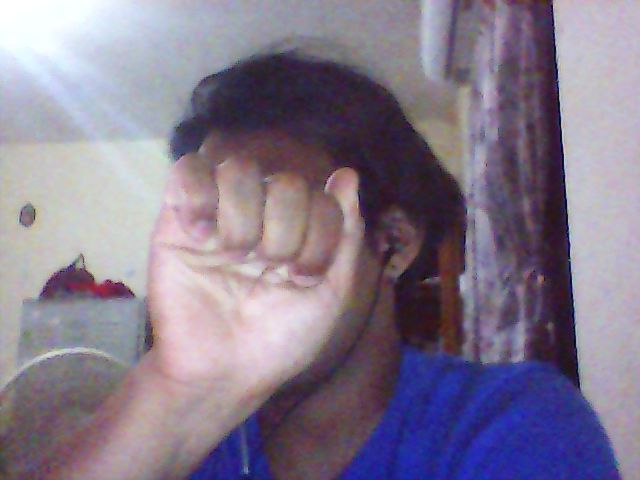

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Generamos los landmarks de la imagen que acabamos de capturar:

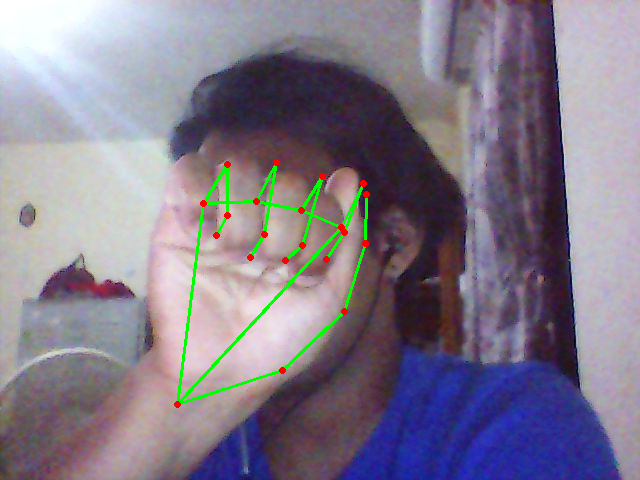

In [ ]:
img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
DrawLandmarks(img)
cv2_imshow(img)

In [ ]:
clf = joblib.load("/models/sign_decoder_svm.pkl")

_, landmarks = GenerateSingleLandmarkFromFile('photo.jpg')
clf.predict([landmarks])

array(['A'], dtype='<U1')

**Conclusiones:**
  
    
Este proyecto me dio la oportunidad de introducirme en las herramientas que se utilizan para el Machine Learning y para tener una idea lo que se puede hacer con las mismas. Quede satisfecho con el resultado y de igual manera me motiva para seguir trabajando con el de forma más avanzada en los próximos cursos que llevaré. En el proceso tuve muchas dificultades al tratar de compactarlo en una aplicación móvil. Algunas letras presentaron un error en el reconocimiento, ya sea por la postura, entorno de la fotografia y mano utilizada (izquierda). En si como un proyecto inicial, el método es bastante didactico cuando no sabes nada acerca de aprendizaje supervisado y otros conceptos más abstractos, porque la libreria realiza todo el trabajo por el usuario.
  
    
**Fuentes:**
  
  
1. https://www.nidcd.nih.gov/health/american-sign-language
2. https://www.kaggle.com/grassknoted/asl-alphabet/code?datasetId=23079
3. https://scikit-learn.org/stable/about.html
4. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
5. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
6. https://scikit-learn.org/stable/modules/svm.html

In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/ASL-oc.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/ASL-oc.ipynb to html
[NbConvertApp] Writing 1042932 bytes to /content/drive/MyDrive/Colab Notebooks/ASL-oc.html
